## About

This page showcases the work of [Tobias Stadler](https://tobias-stalder.netlify.app/). You can find the original [R](https://www.r-graph-gallery.com/) code on Tobias' GitHub [here](https://github.com/toebR/Tidy-Tuesday/blob/master/hiking/script.R). 

Thanks to him for accepting sharing his work here! Thanks also to [Tomás Capretto](https://tomicapretto.github.io/) who translated this work from R to Python! 🙏🙏

As a teaser, here is the plot we’re gonna try building:

![preview final chart](https://github.com/holtzy/The-Python-Graph-Gallery/blob/master/static/graph/web-circular-barplot-with-matplotlib-square.png?raw=true)

## Load libraries

<!-- The first step is always to import some libraries. `NumPy` is going to be used to make some computations with arrays and `load_penguins()` is imported from the `palmerpenguins` library to have access to the popular dataset. -->

Let's load libraries and utilities that are going to be used today. [`textwrap`](https://docs.python.org/3/library/textwrap.html) is Python built-in module that contains several utilities to wrap text. In this post, it is going to help us to split long names into multiple lines.

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from matplotlib.cm import ScalarMappable
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from textwrap import wrap

## Load and prepare the data

This guide shows how to create a beautiful circular barplot to visualize several characteristics of hiking locations in Washington.

The data for this post comes from [Washington Trails Association](https://www.wta.org/go-outside/hikes?b_start:int=1) courtesy of the [TidyX crew](https://github.com/thebioengineer/TidyX/tree/master/TidyTuesday_Explained/035-Rectangles), [Ellis Hughes](https://twitter.com/Ellis_hughes) and [Patrick Ward](https://twitter.com/OSPpatrick). This guide uses the dataset released for the [TidyTuesday](https://github.com/rfordatascience/tidytuesday) initiative on the week of 2020-11-24. You can find the original announcement and more information about the data [here](https://github.com/rfordatascience/tidytuesday/tree/master/data/2020/2020-11-24). Thank you all for making this possible!

Let's start by loading and exploring the first rows of the dataset.

In [2]:
path = 'https://raw.githubusercontent.com/holtzy/The-Python-Graph-Gallery/master/static/data/hike_data.csv'
data = pd.read_csv(path)
data.head()

,name,location,length,gain,highpoint,rating,description
0,Lake Hills Greenbelt,Puget Sound and Islands -- Seattle-Tacoma Area,"2.3 miles, roundtrip",50,330.0,3.67,Hike through a pastoral area first settled and...
1,Snow Lake,Snoqualmie Region -- Snoqualmie Pass,"7.2 miles, roundtrip",1800,4400.0,4.16,A relatively short and easy hike within a ston...
2,Skookum Flats,Mount Rainier Area -- Chinook Pass - Hwy 410,"7.8 miles, roundtrip",300,2550.0,3.68,Choose between a shorter or longer river walk ...
3,Teneriffe Falls,Snoqualmie Region -- North Bend Area,"5.6 miles, roundtrip",1585,2370.0,3.92,You'll work up a sweat on this easy to moderat...
4,Twin Falls,Snoqualmie Region -- North Bend Area,"2.6 miles, roundtrip",500,1000.0,4.14,"Visit a trio (yes, trio) of waterfalls just of..."


The first step is to extract the **region** from the `location` column. This is given by the text before the `"--"`.

In [3]:
data["region"] = data["location"].str.split("--", n=1, expand=True)[0]

# Make sure there's no leading/trailing whitespace
data["region"] = data["region"].str.strip() 

A similar approach is used to extract the **number of miles**.

In [4]:
# Make sure to use .astype(Float) so it is numeric.
data["length_num"] = data["length"].str.split(" ", n=1, expand=True)[0].astype(float)

Now it's time to compute the **cumulative length** and **mean gain** for each region, as well as recording the **number of tracks** per region.

In [5]:
summary_stats = data.groupby(["region"]).agg(
    sum_length = ("length_num", "sum"),
    mean_gain = ("gain", "mean")
).reset_index()

summary_stats["mean_gain"] = summary_stats["mean_gain"].round(0)

trackNrs = data.groupby("region").size().to_frame('n').reset_index()

Finally, merge `summary_stats` with `tracksNrs` to get the final dataset.

In [6]:
summary_all = pd.merge(summary_stats, trackNrs, "left", on = "region")
summary_all.head()

,region,sum_length,mean_gain,n
0,Central Cascades,2130.85,2260.0,226
1,Central Washington,453.30,814.0,80
2,Eastern Washington,1333.64,1591.0,143
3,Issaquah Alps,383.11,973.0,77
4,Mount Rainier Area,1601.80,1874.0,196


## Basic radar plot

Radar charts plot data points in a circular layout. Instead of horizontal and vertical axes, it has an **angular** and a **radial** axis for **x** and **y**, respectively. In this world, **x** values are given by **angles** and **y** values are a **distance** from the center of the circle.

In the chart we're just about to build, the **x** axis will represent the **regions**, and the **y** axis will represent their **cumulative length** and **mean gain**. Color is going to represent the **number of tracks**. Before getting started, just note the values of **x**, given in angles, have to be manually calculated and passed to Matplotlib. This is what is going on in the `np.linspace()` that defines the `ANGLES` variable.

In [7]:
# Bars are sorted by the cumulative track length
df_sorted = summary_all.sort_values("sum_length", ascending=False)

# Values for the x axis
ANGLES = np.linspace(0.05, 2 * np.pi - 0.05, len(df_sorted), endpoint=False)

# Cumulative length
LENGTHS = df_sorted["sum_length"].values

# Mean gain length
MEAN_GAIN = df_sorted["mean_gain"].values

# Region label
REGION = df_sorted["region"].values

# Number of tracks per region
TRACKS_N = df_sorted["n"].values

As usually, colors and other important values are declared before the code that actually produces the plot. In addition, the following chunk also sets the default font to **Bell MT**. For a step-by-step guide on how to install and load custom fonts in Matplotlib, have a look a [this post](https://python-graph-gallery.com/custom-fonts-in-matplotlib).

In [8]:
GREY12 = "#1f1f1f"

# Set default font to Bell MT
plt.rcParams.update({"font.family": "Bell MT"})

# Set default font color to GREY12
plt.rcParams["text.color"] = GREY12

# The minus glyph is not available in Bell MT
# This disables it, and uses a hyphen
plt.rc("axes", unicode_minus=False)

# Colors
COLORS = ["#6C5B7B","#C06C84","#F67280","#F8B195"]

# Colormap
cmap = mpl.colors.LinearSegmentedColormap.from_list("my color", COLORS, N=256)

# Normalizer
norm = mpl.colors.Normalize(vmin=TRACKS_N.min(), vmax=TRACKS_N.max())

# Normalized colors. Each number of tracks is mapped to a color in the 
# color scale 'cmap'
COLORS = cmap(norm(TRACKS_N))

Excited about how to make it? Let's do it!

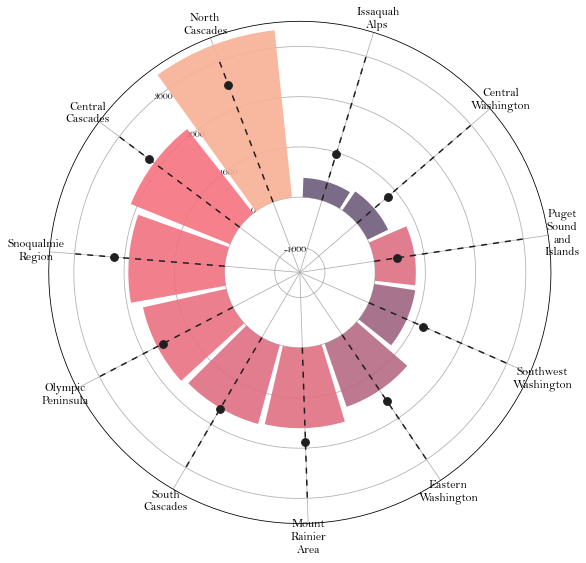

In [9]:
# Some layout stuff ----------------------------------------------
# Initialize layout in polar coordinates
fig, ax = plt.subplots(figsize=(9, 12.6), subplot_kw={"projection": "polar"})

# Set background color to white, both axis and figure.
fig.patch.set_facecolor("white")
ax.set_facecolor("white")

ax.set_theta_offset(1.2 * np.pi / 2)
ax.set_ylim(-1500, 3500)

# Add geometries to the plot -------------------------------------
# See the zorder to manipulate which geometries are on top

# Add bars to represent the cumulative track lengths
ax.bar(ANGLES, LENGTHS, color=COLORS, alpha=0.9, width=0.52, zorder=10)

# Add dashed vertical lines. These are just references
ax.vlines(ANGLES, 0, 3000, color=GREY12, ls=(0, (4, 4)), zorder=11)

# Add dots to represent the mean gain
ax.scatter(ANGLES, MEAN_GAIN, s=60, color=GREY12, zorder=11)


# Add labels for the regions -------------------------------------
# Note the 'wrap()' function.
# The '5' means we want at most 5 consecutive letters in a word, 
# but the 'break_long_words' means we don't want to break words 
# longer than 5 characters.
REGION = ["\n".join(wrap(r, 5, break_long_words=False)) for r in REGION]
REGION

# Set the labels
ax.set_xticks(ANGLES)
ax.set_xticklabels(REGION, size=12);

Pretty good start! It wasn't too complicated to map the variable onto the different geometries in the plot. 

## Customize guides and annotations

The plot above looks quite nice for a start. But so many reference lines are unnecesary. Let's remove these defaults and improve this chart with custom annotations and guides.

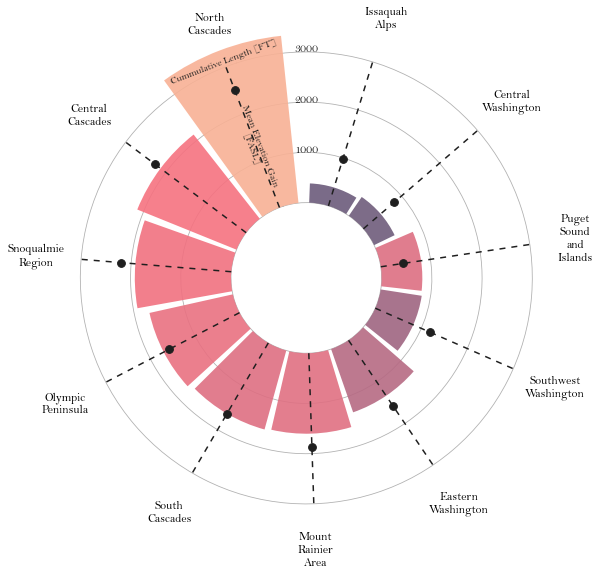

In [10]:
# Remove unnecesary guides ---------------------------------------

# Remove lines for polar axis (x)
ax.xaxis.grid(False)

# Put grid lines for radial axis (y) at 0, 1000, 2000, and 3000
ax.set_yticklabels([])
ax.set_yticks([0, 1000, 2000, 3000])

# Remove spines
ax.spines["start"].set_color("none")
ax.spines["polar"].set_color("none")


# Adjust padding of the x axis labels ----------------------------
# This is going to add extra space around the labels for the 
# ticks of the x axis.
XTICKS = ax.xaxis.get_major_ticks()
for tick in XTICKS:
    tick.set_pad(10)


# Add custom annotations -----------------------------------------
# The following represent the heights in the values of the y axis
PAD = 10
ax.text(-0.2 * np.pi / 2, 1000 + PAD, "1000", ha="center", size=12)
ax.text(-0.2 * np.pi / 2, 2000 + PAD, "2000", ha="center", size=12)
ax.text(-0.2 * np.pi / 2, 3000 + PAD, "3000", ha="center", size=12)


# Add text to explain the meaning of the height of the bar and the
# height of the dot
ax.text(ANGLES[0], 3100, "Cummulative Length [FT]", rotation=21, 
        ha="center", va="center", size=10, zorder=12)
ax.text(ANGLES[0]+ 0.012, 1300, "Mean Elevation Gain\n[FASL]", rotation=-69, 
        ha="center", va="center", size=10, zorder=12)
fig

## Final chart

The result looks much better! The clutter in the previous plot has dissapeared, that's great! The last step is to add a legend that makes the colors more meaningful and a good title and annotations that can easily transmit what this chart is about.

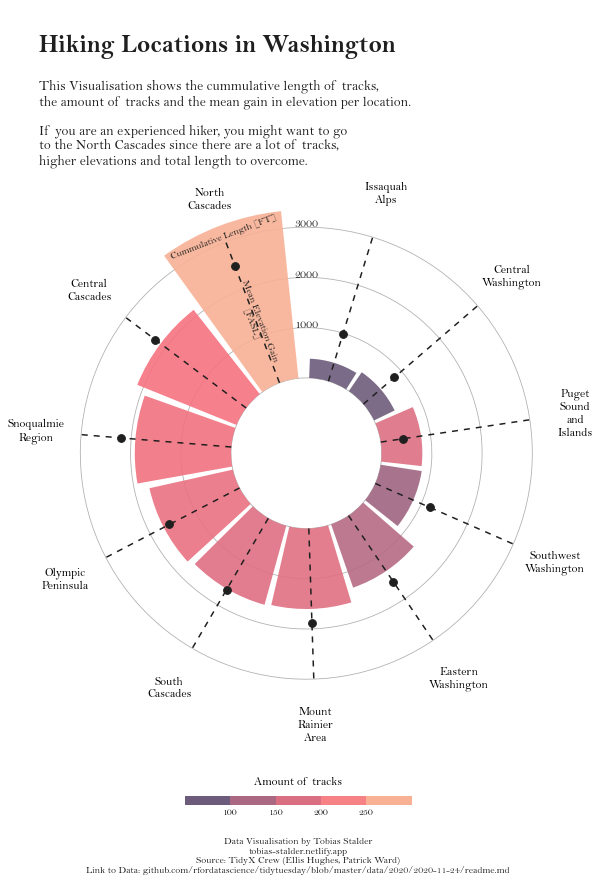

In [11]:
# Add legend -----------------------------------------------------

# First, make some room for the legend and the caption in the bottom.
fig.subplots_adjust(bottom=0.175)

# Create an inset axes.
# Width and height are given by the (0.35 and 0.01) in the 
# bbox_to_anchor
cbaxes = inset_axes(
    ax, 
    width="100%", 
    height="100%", 
    loc="center",
    bbox_to_anchor=(0.325, 0.1, 0.35, 0.01),
    bbox_transform=fig.transFigure # Note it uses the figure.
) 

# Create a new norm, which is discrete
bounds = [0, 100, 150, 200, 250, 300]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

# Create the colorbar
cb = fig.colorbar(
    ScalarMappable(norm=norm, cmap=cmap), 
    cax=cbaxes, # Use the inset_axes created above
    orientation = "horizontal",
    ticks=[100, 150, 200, 250]
)

# Remove the outline of the colorbar
cb.outline.set_visible(False)

# Remove tick marks
cb.ax.xaxis.set_tick_params(size=0)

# Set legend label and move it to the top (instead of default bottom)
cb.set_label("Amount of tracks", size=12, labelpad=-40)

# Add annotations ------------------------------------------------

# Make some room for the title and subtitle above.
fig.subplots_adjust(top=0.8)

# Define title, subtitle, and caption
title = "\nHiking Locations in Washington"
subtitle = "\n".join([
    "This Visualisation shows the cummulative length of tracks,",
    "the amount of tracks and the mean gain in elevation per location.\n",
    "If you are an experienced hiker, you might want to go",
    "to the North Cascades since there are a lot of tracks,",
    "higher elevations and total length to overcome."
])
caption = "Data Visualisation by Tobias Stalder\ntobias-stalder.netlify.app\nSource: TidyX Crew (Ellis Hughes, Patrick Ward)\nLink to Data: github.com/rfordatascience/tidytuesday/blob/master/data/2020/2020-11-24/readme.md"

# And finally, add them to the plot.
fig.text(0.1, 0.93, title, fontsize=25, weight="bold", ha="left", va="baseline")
fig.text(0.1, 0.9, subtitle, fontsize=14, ha="left", va="top")
fig.text(0.5, 0.025, caption, fontsize=10, ha="center", va="baseline")

# Note: you can use `fig.savefig("plot.png", dpi=300)` to save it with in hihg-quality.
fig

Simple and beautiful!